<div align="center">

# Graph-Based Filtering

</div>
<br>

With the emergence of graph-based semantic systems like graph RAGS, a different approach from the standard vector anomaly detection can be applied in Muzlin. This system leverages graph neural networks to find anomalies within graphs such as entity-relationship types. By applying a regression model the graph-based anomaly scores can be mapped with semantic vectors related to the graph nodes. This allows the capability of assigning graph-based anomaly scores to unseen data that is not mapped to the graph.


Why is this useful? 

While you might have built a graph-based RAG or other system, you can still use the standard vector-based anomaly detection as a filter. However, using graph-based filtering instead may provide a better aligned filter for your graph-based system.

# Let's get started!

To begin, first it is recommended to install the necessary libraries to work with the notebooks



In [ ]:
#!pip install -q muzlin[graph] # Required for torch_geometric to work
!pip install -q muzlin[notebook]

Now that we have everything installed, let's import the precomputed graph-based system. In the example below we are using the outputs automatically constructed when you build a graph-based RAG using Microsoft's [graphrag](https://github.com/microsoft/graphrag). 

Note that to use Muzlin's graph-based filtering, the graph must always be a networkx graph

In [1]:
import networkx as nx
import numpy as np
import pandas as pd

data = pd.read_parquet('create_base_entity_graph.parquet')
graphml_data = data.iloc[0]['clustered_graph']
graph = nx.parse_graphml(graphml_data.encode('utf-8'))

Let's take a quick look at the graph itself.

In [2]:
print(graph)

Graph with 891 nodes and 364 edges


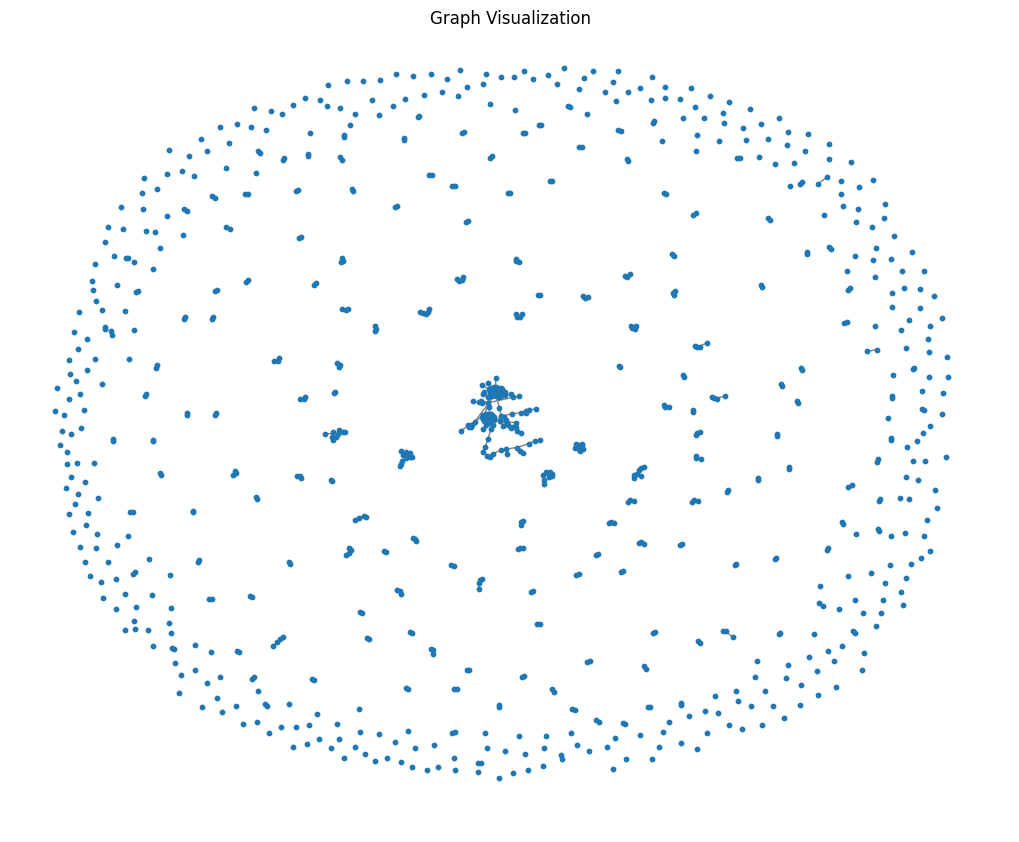

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
pos = nx.spring_layout(graph)

nx.draw(graph, pos, with_labels=False, node_size=10, 
        font_size=1, font_weight='bold', edge_color='gray')

plt.title("Graph Visualization")
plt.show()

Besides the networkx graph we will also need the text that maps to each node of the graph.

In [4]:
docs = pd.read_parquet('create_base_text_units.parquet')
sids = docs['id'].values.tolist()

Muzlin uses two key componets of the networkx graph when constructing a graph-based filter: the *edge-index* and a paramater called *x*. In our graph, *x* will be the vector encodings of the text associated with that node. 

If your graph based system does not alraedy possess this attribute, then this will need to be added to the graph. Below is a simple example of how to do this.

In [5]:
def preprocess_graph(graph, docs, sids, encoder):

    nodes_to_remove = []

    for i, (node, attr) in enumerate(graph.nodes(data=True)):

        # Get the id links between the text and the graph node
        # Luckily using graphrag this is done simply
        source_ids = attr['source_id'].split(',')

        # Some nodes might have multiple text chunks linked and these need to be joined
        texts = ''
        for source_id in source_ids:
            
            if source_id in sids:

                texts += docs['chunk'].loc[docs['id'] == source_id].values[0] + '\n'

        # Now we can give the graph its x value by encoding the linked text
        if texts != '':
            vector = encoder([texts])[0]
            graph.nodes[node].clear()
            graph.nodes[node]['x'] = vector
        else:
            nodes_to_remove.append(node) # Remove nodes that have no text associated with them

    graph.remove_nodes_from(nodes_to_remove)

    return graph

Lets apply our preprocessing step to the networkx graph

In [6]:
from muzlin.encoders import HuggingFaceEncoder

encoder = HuggingFaceEncoder()

graph = preprocess_graph(graph, docs, sids, encoder)

Awesome!

Now we have processed data that is ready to be used to help generate our graph-based filter.

So lets do it

In [7]:
from muzlin.anomaly import GraphOutlierDetector
from pygod.detector import AnomalyDAE

# List of best tested graph based OD models AnomalyDAE, ANOMALOUS

# Initialize graph anomaly detection model 
contamination = 0.1
od = AnomalyDAE(contamination=contamination)

# Set mlflow to true to log the experiment
#import mlflow
#mlflow.set_experiment('graph_outlier_model')
clf = GraphOutlierDetector(mlflow=False, detector=od)
clf.fit(graph)
#mlflow.end_run()

2024-10-18 22:22:19 INFO muzlin.utils.logger No regression model was provided defaulting to RidgeCV.


GraphOutlierDetector()

So a graph-based anaomaly detector was fit to the graph data and the outlier likelihood scores where computed. These scores were mapped with vectors that corresponded to each node using a regression model (which you can also give as an input if you want). But how well did both the anomaly detection and the mapping perform?

Well a first good look is to see visually how the outlier likelihood scores are distributed. 

Note that higher scores mean more anomalous.

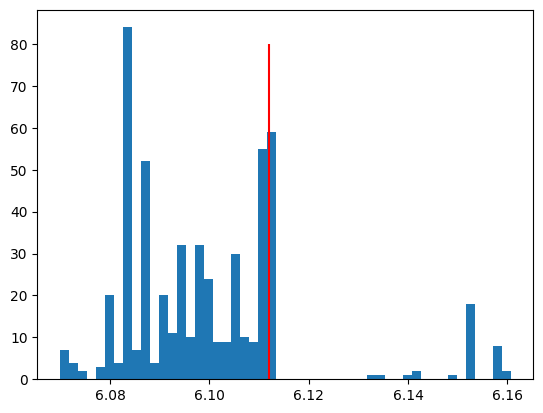

In [8]:
import matplotlib.pyplot as plt

scores = clf.decision_scores_

# Lets get the 90th percentile which was our inital contamination guess
perc = np.percentile(scores, 100 - contamination*100)

# Bin the data and we can see that our initial first guess was good (albeit too strict)
# Here the red line is the threshold and we can see that the majority of the data sits to the left
# and the right tail is the outliers. Perhaps a little less contamination would be a better fit
plt.hist(scores, bins=50)
plt.vlines(perc, 0, 80, colors='r')
plt.show()

We can also see this on the graph to make a quick inspection if the right nodes were set as anamalous

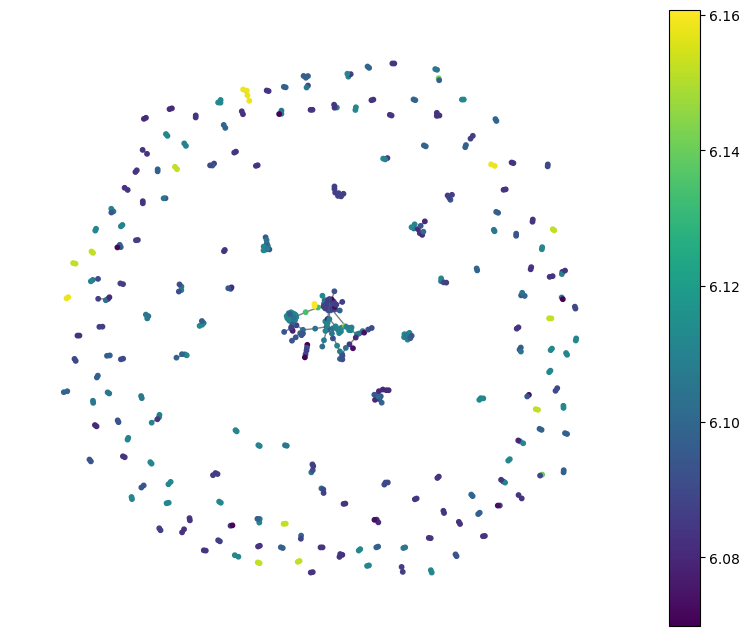

In [9]:
scores = clf.decision_scores_

fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(graph)  # Layout for positioning the nodes
nx.draw(graph, pos, with_labels=False, node_color=scores, node_size=10, 
        font_size=1, font_weight='bold', edge_color='gray', cmap=plt.cm.viridis)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=scores.min(), vmax=scores.max()))
sm.set_array([])
plt.colorbar(sm, ax=ax)

plt.show()

From what we can see above, it seems like the main well-connected nodes got low scores while the less conneceted outer nodes were more anomalous as is expected of a well fitted graph-based anomaly detection model.

But how well did the vector regression mapping perform? We can see this by accessing the R2 score of the regression fit on the training data.

Note that even using a well fit graph OD, the R2 score may be low if the regression model cannot fit the vectors to outlier likelihood scores well. A recommendation, before using complex regression models, use the default RidgeCV or another linear model and test by adjusting the `random_state` variable for thie Muzlin `GraphOutlierDetector` as the graph OD can be quite sensetive to this.

In [10]:
print(clf.reg_R2_)

0.9681387281966825


Wow! The regression R2 score shows that the mapping is really good.

With our model looking all good, we can start using it to filter new data

In [11]:
from muzlin.anomaly import GraphOutlierDetector
from muzlin.encoders import HuggingFaceEncoder

# Preload trained model - required
clf = GraphOutlierDetector(model='outlier_detector.pkl', 
                           egressor_model='regressor.pkl')

# Encode question
encoder = HuggingFaceEncoder()

question = encoder(['Who is the current president of the USA?']) # This is a clear outlier
#question = encoder(['What treatment raises endoplasmic reticulum stress?']) # This is a clear inlier
#question = encoder(['What dosage affects the kidneys?']) # Unlike just using vector OD this is now a clear inlier
#question = encoder(['Does taking too much folic acid affect kidney disease?']) # Unlike just using vector OD this is now a clear inlier


vector = np.array(question).reshape(1,-1) # Must be 2D

# Get a binary inlier 0 or outlier 1 output
label = clf.predict(vector)
score = clf.decision_function(vector)

print('Inlier 0, Outlier 1:', label[0])
print('Outlier likelihood:', score[0])

Inlier 0, Outlier 1: 1
Outlier likelihood: 6.128519839305534


<br>

So a graph-based filter has now been built and tested. 

But, it can be further improved by using threshold optimization. If you are interested, you can take a look at the semi-supervised method as given in the 01_Threshold_Optimization notebook.